In [1]:
#importing libraries and packages
import sys,os,time
from io import StringIO  # Add this line
print(sys.executable)
import pandas as pd
#from datetime import datetime
from datetime import datetime, timedelta
import numpy as np
#import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.markers
from pandas.tseries.frequencies import to_offset# needed to set the time offset to match to the muons DF
import seaborn as sns
from numpy import argmax
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.datasets import make_regression
from sklearn.preprocessing import LabelEncoder
from pytz import timezone
#from tensorflow.keras import Sequential
#from tensorflow.keras.layers import Dense
#import tensorflow as tf
#import pylab as plt
#import ROOT

/usr/bin/python3


In [2]:
"""
Example script that scrapes data from the IEM ASOS download service
"""
from __future__ import print_function
import json
import time
from datetime import datetime, timedelta
#import datetime
import pandas as pd

# Python 2 and 3: alternative 4
try:
    from urllib.request import urlopen
except ImportError:
    from urllib2 import urlopen

# Number of attempts to download data
MAX_ATTEMPTS = 6
# HTTPS here can be problematic for installs that don't have Lets Encrypt CA
SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"


def download_data(uri):
    """Fetch the data from the IEM
    The IEM download service has some protections in place to keep the number
    of inbound requests in check.  This function implements an exponential
    backoff to keep individual downloads from erroring.
    Args:
      uri (string): URL to fetch
    Returns:
      string data
    """
    attempt = 0
    while attempt < MAX_ATTEMPTS:
        try:
            data = urlopen(uri, timeout=300).read().decode("utf-8")
            if data is not None and not data.startswith("ERROR"):
                return data
        except Exception as exp:
            print("download_data(%s) failed with %s" % (uri, exp))
            time.sleep(5)
        attempt += 1

    print("Exhausted attempts to download, returning empty data")
    return ""


def get_stations_from_filelist():
    """Build a listing of stations from a simple file listing the stations.
    The file should simply have one station per line.
    """
    stations = []
    for line in open(filename):
        stations.append(line.strip())
    return stations


def get_stations_from_networks():
    """Build a station list by using a bunch of IEM networks."""
    stations = ["ATL"]
    states = "GA"
    # IEM quirk to have Iowa AWOS sites in its own labeled network
    networks = ["AWOS"]
    for state in states.split():
        networks.append("%s_ASOS" % (state,))

    for network in networks:
        # Get metadata
        uri = (
            "https://mesonet.agron.iastate.edu/" "geojson/network/%s.geojson"
        ) % (network,)
        data = urlopen(uri)
        jdict = json.load(data)
        for site in jdict["features"]:
            stations.append(site["properties"]["sid"])
    return stations

def get_weather_data(start_date, end_date):#this function not called here just for reference 
    """Our main method"""
    # timestamps in UTC to request data for
    startts = start_date
    endts = end_date

    service = SERVICE + "data=all&tz=Etc/UTC&format=comma&latlon=yes&"

    service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
    service += endts.strftime("year2=%Y&month2=%m&day2=%d&")

    # Two examples of how to specify a list of stations
    #stations = get_stations_from_networks()
    #stations = get_stations_from_filelist("stations.txt")
    
    
    #station name and parameter can be found from following the website
    #https://mesonet.agron.iastate.edu/request/download.phtml
    stations = ["VCBI","SKSM","ATL"]  
    data_types = ["tmpf","alti"] #mslp: pressure , tmpf: temperature in F , alti: altitude in inches
    for station in stations:
        
        for station in stations:
            for data_type in data_types:
                service = SERVICE + "data=" + data_type + "&tz=Etc/UTC&format=onlytdf&=yes&"
                service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
                service += endts.strftime("year2=%Y&month2=%m&day2=%d&")
                uri = "%s&station=%s" % (service, station)
                print("Downloading: %s" % (station,))
                data = download_data(uri)
                outfn = "%s_%s.csv" % (
                    station,
                    data_type
                )
                out = open(outfn, "w")
                out.write(data)
                out.close()
                df = pd.read_csv(outfn, sep='\t')
                print(df)
def main():
    
    """Our main method"""
    # timestamps in UTC to request data for
    startts = datetime.utcnow().date() - timedelta(days=1095)#datetime.datetime(2020, 6, 15)
    endts   = datetime.utcnow().date()
    
    
    # Two examples of how to specify a list of stations
    #stations = get_stations_from_networks()
    # stations = get_stations_from_filelist("mystations.txt")
    
    stations = ["VCBI"]
    dfs = []   
    data_types = ["alti", "tmpf"]
    for station in stations:
        
        for data_type in data_types:
     
            service = SERVICE + "data="+data_type+"&tz=Etc/UTC&format=onlytdf&=yes&"

            service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
            service += endts.strftime("year2=%Y&month2=%m&day2=%d&")
    

            
            uri = "%s&station=%s" % (service, station)
            print("Downloading: %s" % (station,))
            data = download_data(uri)
            outfn = "%s_%s_%s.txt" % (
                station,
                startts.strftime("%Y%m%d%H%M"),
                endts.strftime("%Y%m%d%H%M"),
            )
            out = open(outfn, "w")
            out.write(data)
            out.close()
            
            df = pd.read_csv(outfn, sep= '\t' )


            out.close()
            dfs.append(df)




            df.head()
            print(df)
            


    
    final_dataframe = pd.merge(dfs[0], dfs[1])
    print(final_dataframe)
    
    final_dataframe.to_csv("colombo_alti_temp.csv",index = False)




if __name__ == "__main__":
    main()

Downloading: VCBI
      station             valid   alti
0        VCBI  2021-08-14 00:10  29.74
1        VCBI  2021-08-14 01:10  29.77
2        VCBI  2021-08-14 02:10  29.77
3        VCBI  2021-08-14 03:10  29.80
4        VCBI  2021-08-14 04:10  29.80
...       ...               ...    ...
25647    VCBI  2024-08-12 18:10  29.71
25648    VCBI  2024-08-12 19:10  29.71
25649    VCBI  2024-08-12 20:10  29.71
25650    VCBI  2024-08-12 21:10  29.68
25651    VCBI  2024-08-12 22:10  29.68

[25652 rows x 3 columns]
Downloading: VCBI
      station             valid   tmpf
0        VCBI  2021-08-14 00:10  80.60
1        VCBI  2021-08-14 01:10  80.60
2        VCBI  2021-08-14 02:10  80.60
3        VCBI  2021-08-14 03:10  82.40
4        VCBI  2021-08-14 04:10  82.40
...       ...               ...    ...
25647    VCBI  2024-08-12 18:10  77.00
25648    VCBI  2024-08-12 19:10  77.00
25649    VCBI  2024-08-12 20:10  77.00
25650    VCBI  2024-08-12 21:10  77.00
25651    VCBI  2024-08-12 22:10  77.00

[

In [4]:
'''from datetime import datetime, timedelta
def merge_tables(df1, dfpt):
    t1start=pd.Timestamp(df1.index[0])
    t1end=pd.Timestamp(df1.index[-1])
    print(t1start,t1end)
    dfpt1 = dfpt.loc[t1start:t1end].copy()
    merged_tab=pd.merge(df1,dfpt1, how='inner', left_index=True, right_index=True)
    return merged_tab
 '''

"from datetime import datetime, timedelta\ndef merge_tables(df1, dfpt):\n    t1start=pd.Timestamp(df1.index[0])\n    t1end=pd.Timestamp(df1.index[-1])\n    print(t1start,t1end)\n    dfpt1 = dfpt.loc[t1start:t1end].copy()\n    merged_tab=pd.merge(df1,dfpt1, how='inner', left_index=True, right_index=True)\n    return merged_tab\n "

In [5]:
def merge_tables(df1, dfpt):
    # Ensure index is datetime type
    df1.index = pd.to_datetime(df1.index)
    dfpt.index = pd.to_datetime(dfpt.index)
    
    # Sort DataFrames by index
    df1.sort_index(inplace=True)
    dfpt.sort_index(inplace=True)
    
    # Merge DataFrames using inner join
    merged_tab = pd.merge(df1, dfpt, how='inner', left_index=True, right_index=True)
    
    return merged_tab


In [6]:
def calc_percent_change(merged_df):
    merged_df["counts_pct"] = ((merged_df['counts'] - merged_df['counts'].mean())/ 
                      merged_df['counts'].mean()*100)
    merged_df["counts_m_avg"] = merged_df.rolling('6H').counts_pct.mean()
    merged_df["press_pct"] = 10*((merged_df['alti'] - merged_df['alti'].mean())/ 
                      merged_df['alti'].mean()*100)
    merged_df["temp_pct"] = ((merged_df['tmpf'] - merged_df['tmpf'].mean())/ 
                      merged_df['tmpf'].mean()*100)
    merged_df['temp_scaled'] = 0.3*merged_df['temp_pct']
    #merged_df1["delta_cts"]  = (merged_df1["counts"]-merged_df1["counts"].mean())/merged_df1["counts"]
    #merged_df1["delta_pres"] = (merged_df1["mslp"]-merged_df1["mslp"].mean())/merged_df1["mslp"]
    merged_df["delta_cts"]  = np.log((merged_df["counts"])/merged_df["counts"].mean())
    merged_df["delta_pres"] = (merged_df["alti"]-merged_df["alti"].mean())
    print(merged_df["alti"].mean(),merged_df["alti"].std(), merged_df['counts_pct'].max(), merged_df["counts"].mean(),merged_df["counts_pct"].std())

['2024-04-08T13h10m34s405Z.log', '2023-09-15T21h52m36s894Z.log', '2023-12-10T03h10m50s840Z.log', '2024-03-23T11h46m47s269Z.log', '2024-01-08T15h15m03s912Z.log', '2023-09-20T03h49m36s897Z.log', '2024-03-24T01h06m45s768Z.log', '2024-04-18T03h26m14s308Z.log']
-------
                           counts
date                             
2023-09-15 22:00:00+00:00  5847.0
2023-09-15 23:00:00+00:00  5937.0
2023-09-16 00:00:00+00:00  6028.0
2023-09-16 01:00:00+00:00  5794.0
2023-09-16 02:00:00+00:00  5835.0
...                           ...
2024-04-23 15:00:00+00:00  4859.0
2024-04-23 16:00:00+00:00  5020.0
2024-04-23 18:00:00+00:00  4636.0
2024-04-23 19:00:00+00:00  5275.0
2024-04-23 20:00:00+00:00  5663.0

[4805 rows x 1 columns]
-------
                      alti  tmpf
valid                           
2021-04-26 01:00:00  29.77  77.0
2021-04-26 02:00:00  29.80  78.8
2021-04-26 03:00:00  29.83  82.4
2021-04-26 04:00:00  29.85  84.2
2021-04-26 05:00:00  29.85  86.0
...                    ...   

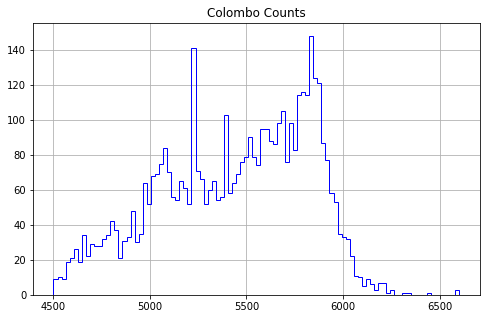

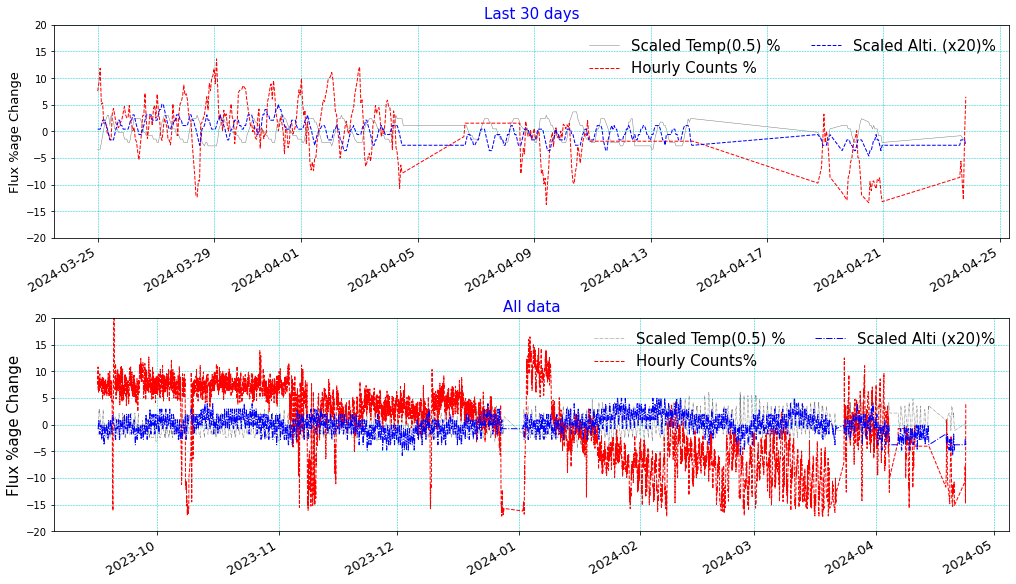

In [9]:
# Specify the directory where your log files are stored
log_directory = '/home/cosmic/Colombo/'

# Get a list of all files in the directory
all_files = os.listdir(log_directory)

# Filter only files with a specific extension (e.g., '.log')
log_files = [file for file in all_files if file.endswith('.log')]

print(log_files)

# Initialize an empty DataFrame
merged_df1 = pd.DataFrame()

# Iterate through each log file
for log_file in log_files:
    # Create the full path for the log file
    log_file_path = os.path.join(log_directory, log_file)
  
    # Read the log file into a DataFrame
    with open(log_file_path, 'r') as file:
        log_content = file.read()
        df = pd.read_csv(StringIO(log_content), sep=',')
        
        # Merge the current DataFrame with the overall DataFrame
        merged_df1 = pd.concat([merged_df1, df], axis=0, ignore_index=True)


#merged_df= merged_df['One and Two'].str.split(",", n = 12,expand = True)      
# Convert the 'datetime' column to datetime format
merged_df1['date'] = pd.to_datetime(merged_df1['date'], errors='coerce')
#merged_df['One and Two'] = merged_df['One and Two'].astype(str)

#merged_df= merged_df['One and Two'].str.split(" ", n = 3,expand = True)

#print(merged_df1)

# Check for missing values in the 'date' column
if merged_df1['date'].isna().any():
    # Drop rows with null values in the 'date' column
    merged_df1 = merged_df1.dropna(subset=['date'])
    
    # Sort the DataFrame based on the 'date' column
    merged_df1 = merged_df1.sort_values(by='date')
    
    # Create a continuous date-time range
    date_range = pd.date_range(start=merged_df1['date'].min(), end=merged_df1['date'].max(), freq='1T')

    # Create a DataFrame with the continuous date-time range
    continuous_datetime_df = pd.DataFrame({'date': date_range})
    
    # Merge the original DataFrame with the continuous date-time DataFrame
    merged_df1 = pd.merge_asof(continuous_datetime_df, merged_df1, on='date', direction='nearest')
   
    # Fill NaN values in columns other than 'date' with NaN
    merged_df1 = merged_df1.reindex(columns=merged_df1.columns, fill_value=pd.NaT)

    # Print the resulting DataFrame
    #print(merged_df1)
else:
    # No missing values in 'date' column
    print(merged_df1)
    
named_df = pd.DataFrame(merged_df1.values, columns=['date', "junk1", "junk2", "junk", 'counts', "junk", "junk", "junk", "junk", "junk", "junk", "junk"])
named_df['counts'] = named_df['counts'].replace(',', '', regex=True)
named_df = named_df.set_index('date')
named_df.index = pd.to_datetime(named_df.index)

named_df['counts'] = named_df['counts'].apply(pd.to_numeric)

# Drop unnecessary columns from 'named_df'
named_df = named_df[['counts']]

df_hourly = named_df.resample('H').sum()

df_hourly.drop(df_hourly.head(1).index, inplace=True)
df_hourly.drop(df_hourly.tail(1).index, inplace=True)


df_hourly.drop(df_hourly[df_hourly['counts'] < 4500].index, inplace = True)
df_hourly.drop(df_hourly[df_hourly['counts'] > 7150].index, inplace = True)

print("-------")
print(df_hourly)
print("-------")

fPT1    ='colombo_alti_temp.csv'
df1_PT  = pd.read_csv(fPT1)
df1_PT.drop(df1_PT[df1_PT['alti'] == 'M'].index, inplace = True)
df1_PT.drop(df1_PT[df1_PT['tmpf'] == 'M'].index, inplace = True)
df1_PT.dropna(inplace=True)
df1_PT['valid'] = pd.to_datetime(df1_PT['valid'])
df1_PT = df1_PT.set_index('valid')
df1_PT = df1_PT.drop(columns=["station"])
loffset = '+50min'
df1_PT.index = df1_PT.index + to_offset(loffset)
df1_PT["alti"] = df1_PT["alti"].astype(str).astype(float)
df1_PT["tmpf"] = df1_PT["tmpf"].astype(str).astype(float)

df1_PT.index = df1_PT.index.tz_localize(None)
df_hourly.index = df_hourly.index.tz_localize(None)

print(df1_PT)


merged_df1= merge_tables(df1_PT,df_hourly)
print("-------")
print(merged_df1)
print("-------")

plt.rcParams["axes.grid"] = True
fig, (ax1) = plt.subplots(1,figsize=(8, 5))
ax1.hist(merged_df1['counts'], bins=100,histtype='step',label='Counts',color='blue')
ax1.set_title('Colombo Counts')

from datetime import datetime, timedelta
now = datetime.utcnow().date()
yesterday = datetime.utcnow().date() - timedelta(days=1)
lastmonth = datetime.utcnow().date() - timedelta(days=31)
print(now)
print(yesterday)
print(lastmonth)
#mask = (merged_df1['date'] > yesterday) & (merged_df1['date'] <= now)
#merged_df1.loc[mask]
merged_df1_1day   = merged_df1.loc[yesterday:now].copy()
#merged_df_1day
merged_df1_31days =merged_df1.loc[lastmonth:now].copy()


calc_percent_change(merged_df1)
calc_percent_change(merged_df1_1day)
calc_percent_change(merged_df1_31days)


fig = plt.figure(figsize=(14, 8),constrained_layout=True)
gs = fig.add_gridspec(2)
axs = gs.subplots(sharex=False, sharey=False)

#axs[0].set_title('Last 24 hours:'+str(yesterday)+' to ' +str(now),fontsize=15,color='blue')
#axs[0].plot(merged_df1_1day['temp_scaled'],
#linestyle='-', linewidth=0.5, color='gray', label='scaled Temp(0.1) %')
#axs[0].plot(merged_df1_1day['counts_m_avg'],
#linestyle='--', linewidth=2, color='red', label='Running avg (6H) %')
#axs[0].plot(merged_df1_1day['press_pct'],
#linestyle='-', linewidth=1, color='blue', label='Press %')


axs[0].set_title("Last 30 days",fontsize=15,color='blue')
axs[0].plot(merged_df1_31days['temp_scaled'],
linestyle='-', linewidth=0.5, color='gray', label='Scaled Temp(0.5) %')
axs[0].plot(merged_df1_31days['counts_pct'],
linestyle='--', linewidth=1, color='red', label='Hourly Counts %')
axs[0].plot(merged_df1_31days['press_pct'],
linestyle='--', linewidth=1, color='blue', label='Scaled Alti. (x20)%')


axs[1].set_title("All data",fontsize=15,color='blue')
axs[1].plot(merged_df1['temp_scaled'],
            linestyle='-.', linewidth=0.5, color='gray', label='Scaled Temp(0.5) %')
axs[1].plot(merged_df1["counts_pct"],
            linestyle='--', linewidth=1, color='red', label='Hourly Counts%')
axs[1].plot(merged_df1["press_pct"],
            linestyle='-.', linewidth=1, color='blue', label='Scaled Alti (x20)%')

axs[0].set_ylabel('Flux %age Change',fontsize=13)
#axs[0].set_ylim([merged_df1_1day['temp_scaled'].min()*1.2, merged_df1_1day['temp_scaled'].max()*1.2])
axs[0].set_ylim(-20,20)
axs[0].legend(ncol=2,frameon=False,fontsize=15);
axs[0].tick_params(axis='x', labelsize=13)
axs[0].grid(True, color = 'DarkTurquoise', alpha=1, linestyle = '--', linewidth = 0.5)


axs[1].set_ylabel('Flux %age Change',fontsize=15)
#axs[1].set_ylim([merged_df1_31days['temp_scaled'].min()*1.3, merged_df1_31days['temp_scaled'].max()*1.3])
axs[1].set_ylim(-20,20)
axs[1].tick_params(axis='x', labelsize=13)
axs[1].legend(ncol=2,frameon=False,fontsize=15)
axs[1].grid(True, color = 'DarkTurquoise', alpha=1, linestyle = '--', linewidth = 0.5)

plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.savefig('/home/cosmic/onlineMon/images/colombo_pct_Ch_mostrecent.png')

# Load Pressure and Temperature Data (alit and tmpf)


# Download the Pressure Temperature file

## Compute the %age change and rolling average¶

-0.2454466343325571 -0.0026176033474422464 -0.17238913039257223 2.4302215607478538e-30 0.021279003141202502


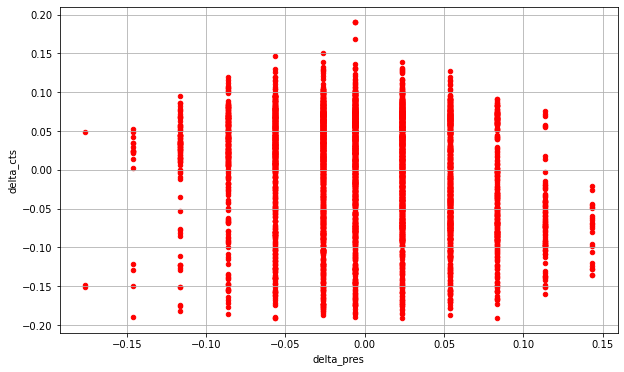

In [7]:
from scipy import stats
#fig, ax = plt.subplots(figsize=(15,10))
slope, intercept, r_value, pv, se = stats.linregress(merged_df1['delta_pres'], merged_df1['delta_cts'])
print(slope, intercept, r_value, pv, se)
plot_P_T = merged_df1.plot.scatter(x='delta_pres',
                   y='delta_cts',
                   c='Red',figsize=(10,6))
baro_coeff = slope;

In [8]:
# pressure correction
merged_df1["Po"]          = merged_df1["alti"].mean()
merged_df1["P-Po"]        = merged_df1["alti"]-merged_df1["Po"]
merged_df1["k(P-Po)"]     = merged_df1["P-Po"]*[-1.0*baro_coeff] # coefficient
#merged_df1["k(P-Po)"]     = merged_df1["k(P-Po)"]
merged_df1["exp"]         = np.exp(merged_df1["k(P-Po)"])
merged_df1["Icorr"]       = merged_df1["counts"]* merged_df1["exp"]
merged_df1["Icorr_pct"] = ((merged_df1['Icorr'] - merged_df1['Icorr'].mean())/ 
                      merged_df1['Icorr'].mean()*100)
merged_df1["Icorr_m_avg"]   = merged_df1.rolling("H").Icorr_pct.mean()
merged_df1                = merged_df1.drop(columns = ["exp","k(P-Po)","k(P-Po)","P-Po"])
merged_df1

,alti,tmpf,counts,counts_pct,counts_m_avg,press_pct,temp_pct,temp_scaled,delta_cts,delta_pres,Po,Icorr,Icorr_pct,Icorr_m_avg
2023-09-15 22:00:00,29.83,77.0,5847.0,7.247238,7.247238,-0.884122,-5.693047,-1.707914,0.069967,-0.026397,29.856397,5809.239872,6.563017,6.563017
2023-09-15 23:00:00,29.83,77.0,5937.0,8.898042,8.072640,-0.884122,-5.693047,-1.707914,0.085242,-0.026397,29.856397,5898.658649,8.203289,8.203289
2023-09-16 00:00:00,29.83,77.0,6028.0,10.567189,8.904157,-0.884122,-5.693047,-1.707914,0.100453,-0.026397,29.856397,5989.070968,9.861787,9.861787
2023-09-16 01:00:00,29.83,77.0,5794.0,6.275098,8.246892,-0.884122,-5.693047,-1.707914,0.060861,-0.026397,29.856397,5756.582148,5.597079,5.597079
2023-09-16 02:00:00,29.85,77.0,5835.0,7.027131,8.002940,-0.214248,-5.693047,-1.707914,0.067912,-0.006397,29.856397,5825.845974,6.867634,6.867634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31 16:00:00,29.88,84.2,5400.0,-0.951755,-2.651472,0.790561,3.125266,0.937580,-0.009563,0.023603,29.856397,5431.374906,-0.368429,-0.368429
2024-03-31 17:00:00,29.88,82.4,5292.0,-2.932720,-2.889921,0.790561,0.920688,0.276206,-0.029766,0.023603,29.856397,5322.747408,-2.361060,-2.361060
2024-03-31 18:00:00,29.88,82.4,5327.0,-2.290741,-2.883807,0.790561,0.920688,0.276206,-0.023174,0.023603,29.856397,5357.950764,-1.715300,-1.715300
2024-03-31 19:00:00,29.88,82.4,5365.0,-1.593735,-2.244885,0.790561,0.920688,0.276206,-0.016066,0.023603,29.856397,5396.171550,-1.014189,-1.014189


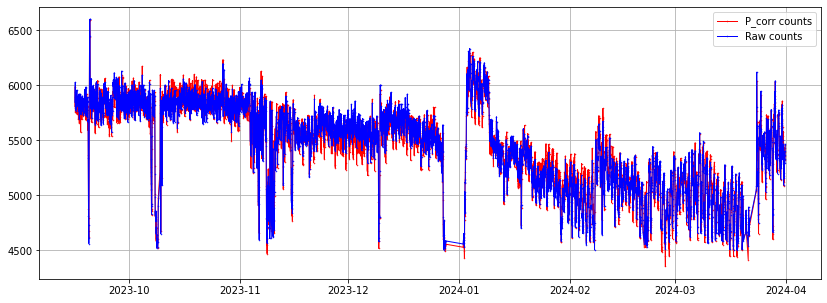

In [9]:
plt.rcParams["axes.grid"] = True
fig, (ax1) = plt.subplots(1,figsize=(14, 5))
#fig.suptitle('Counts')
#ax1.hist(df2_hourly['counts'], bins=100,histtype='step',label='Counts',color='blue')
ax1.plot(merged_df1["Icorr"],
marker='.', markersize=1, linestyle='-', linewidth=1, color='red', label='P_corr counts')
ax1.plot(merged_df1["counts"],
marker='.', markersize=1, linestyle='-', linewidth=1, color='blue', label='Raw counts')
#ax1.set_title('4 Paddle Counts')
#ax1.set_xlim([pd.Timestamp('2020-11-03'), pd.Timestamp('2021-04-20')])
ax1.legend();

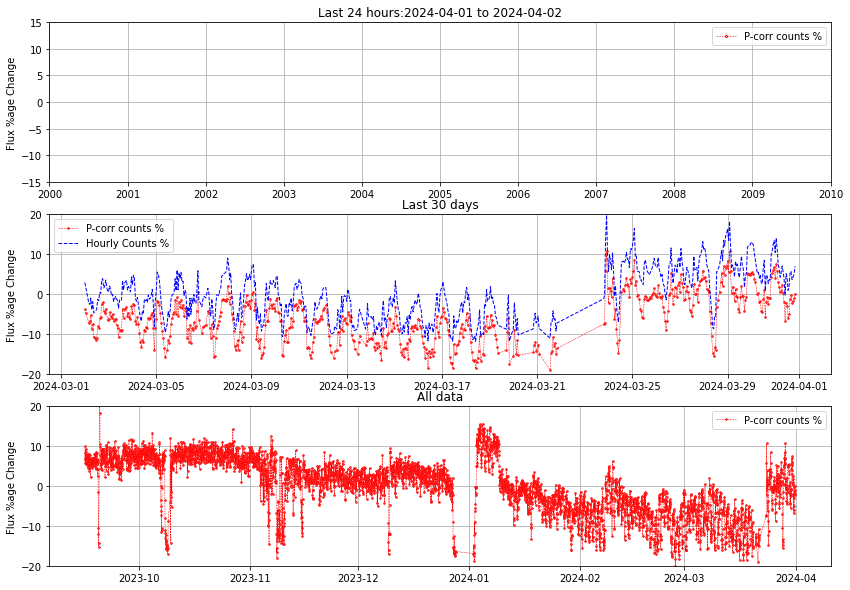

In [10]:
#title1 = now.year()
plt.rcParams["axes.grid"] = True
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3)
axs = gs.subplots(sharex=False, sharey=False)
#fig.suptitle('Flux %age Change (Muon001 Detector)')
#axs[0].set_title("Last 24 hours (yesterday:now)")
axs[0].set_title('Last 24 hours:'+str(yesterday)+' to ' +str(now))
axs[0].plot(merged_df1.loc[yesterday:now, 'Icorr_m_avg'],
markerfacecolor='white',markeredgecolor="red", marker='.', markersize=4, linestyle='--', linewidth=0.5, color='red', label='P-corr counts %')

axs[1].set_title("Last 30 days")
axs[1].plot(merged_df1.loc[lastmonth:now, 'Icorr_m_avg'],
markerfacecolor='white',markeredgecolor="red", marker='.', markersize=3, linestyle='--', linewidth=0.5, color='red', label='P-corr counts %')
axs[1].plot(merged_df1_31days['counts_pct'],
linestyle='--', linewidth=1, color='blue', label='Hourly Counts %')

axs[2].set_title("All data")
axs[2].plot(merged_df1["Icorr_m_avg"],
markerfacecolor='white',markeredgecolor="red", marker='.', markersize=3, linestyle='--', linewidth=0.5, color='red', label='P-corr counts %')
#axs[2].plot(merged_df1["counts_m_avg"],
#markerfacecolor='white',markeredgecolor="blue", marker='o', markersize=3, linestyle='', linewidth=0.5, color='blue', label='P-corr counts %')



#axs[2].plot(df1_hourly["Ch23_m_avg"],
#marker='.', markersize=1, linestyle='-', linewidth=1, color='black', label='Ch23_m_avg')

axs[0].set_ylabel('Flux %age Change')
axs[0].set_ylim([-15, 15])
axs[0].legend();
axs[1].set_ylabel('Flux %age Change')
axs[1].set_ylim([-20, 20])
axs[1].legend();
axs[2].set_ylabel('Flux %age Change')
axs[2].set_ylim([-20, 20])
axs[2].legend();
# Hide x labels and tick labels for all but bottom plot.
#for ax in axs:
 #   ax.label_outer()
plt.savefig('/home/cosmic/onlineMon/images/Colombo_pct_Ch_Pcorr.png')

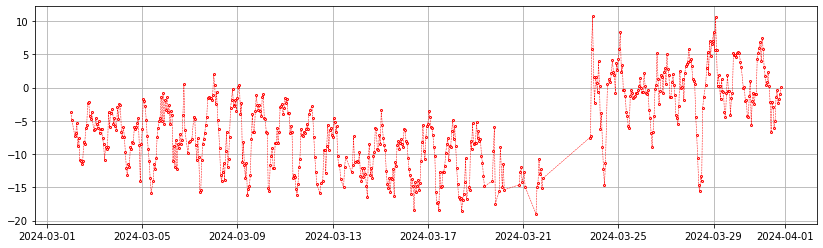

In [18]:

plt.rcParams["axes.grid"] = True
plt.figure(figsize=(14, 4))
#fig = plt.figure(figsize=(14, 10))
#gs = fig.add_gridspec(3)
#axs = gs.subplots(sharex=False, sharey=False)
#fig.suptitle('Flux %age Change (Muon001 Detector)')
#axs[0].set_title("Last 24 hours (yesterday:now)")
#plt.set_title('Last 24 hours:'+str(yesterday)+' to ' +str(now))
plt.plot(merged_df1.loc[lastmonth:now, 'Icorr_m_avg'],
markerfacecolor='white',markeredgecolor="red", marker='.', markersize=4, linestyle='--', linewidth=0.5, color='red', label='P-corr counts %')
